In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Literal
from IPython.display import Image
import operator
from dotenv import load_dotenv
import os

load_dotenv()
strmodel = ChatOpenAI(model=os.getenv("strgpt_model"))

In [3]:
class QuardState(TypedDict):
    a: int
    b: int
    c: int

    equation: str
    discreminant: float
    result: str

In [19]:
def show_equation(state: QuardState):
    equation = f'{state['a']}x2{state['b']}x{state['c']}'
    return {'equation':equation}

def calculate_discreminant(state: QuardState):
    discreminant = state['b']**2 - (4*state['a']*state['c'])
    return {'discreminant': discreminant}


def real_roots(state: QuardState):
    root1 = (-state['b'] + state['discreminant']**0.5)/(2*state['a'])
    root2 = (-state['b'] - state['discreminant']**0.5)/(2*state['a'])
    results = f'The roots are {root1} and {root2}'
    return {'result':results}

def repeated_roots(state: QuardState):
    root = (-state['b'])/(2*state['a'])
    results = f'only repeting root is {root}'
    return {'result':results}

def no_real_roots(state: QuardState):
    results = 'no real roots'
    return {'result':results}

def check_condition(state: QuardState) -> Literal['real_roots','repeated_roots','no_real_roots']:
    if state['discreminant']>0:
        return "real_roots"
    elif state['discreminant']==0:
        return "repeated_roots"
    else:
        return "no_real_roots"

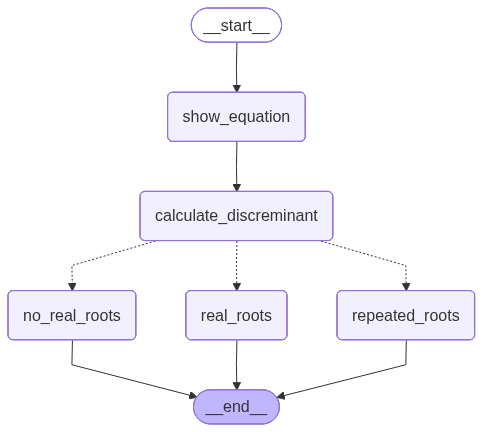

In [21]:
graph = StateGraph(QuardState)

graph.add_node('show_equation',show_equation)
graph.add_node('calculate_discreminant',calculate_discreminant)
graph.add_node('real_roots',real_roots)
graph.add_node('repeated_roots',repeated_roots)
graph.add_node('no_real_roots',no_real_roots)

graph.add_edge(START, 'show_equation')
graph.add_edge('show_equation', 'calculate_discreminant')
graph.add_conditional_edges('calculate_discreminant',check_condition)
graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)

workflow = graph.compile()
Image(workflow.get_graph().draw_mermaid_png())

In [26]:
state = {'a':2,'b':2,'c':-4}
workflow.invoke(state)

{'a': 2,
 'b': 2,
 'c': -4,
 'equation': '2x22x-4',
 'discreminant': 36,
 'result': 'The roots are 1.0 and -2.0'}